# python데이터분석 실무

출처 : https://wikidocs.net/16570 <br>
2020-12-14

### 03. 유저 Funnel 분석을 통해 이탈구간 개선

**데이터 전처리 방식**
> * 데이터 Type, Label 등이 일관적이지 않은 경우
    * 프로그램에서 제공하는 함수를 통해 일괄적으로 변경 (예, SQL: Cast, Python: astype())
* Missing Value
    * 수치형인 경우 Mean, Median 등 대푯값으로 채우거나 실수 예측 모델링 활용 (예, Linear Regression)
    * 카테고리형인 경우 Mode로 채우거나 분류 예측 모델링 활용 (예, Logistic Regression)
* Errors, Typo 발생의 경우
    * 텍스트 처리 함수 활용 (예, Python: str.replace())
* 이상치(outlier)
    * IQR, Z-score, MAD 등 방식으로 이상치 제거
* 변수가 많은 경우(20개 이상)
    * PCA 등으로 차원 축소하거나 변수 중요도 파악후 불필요 변수 제거
* 편향된 분포의 변수가 존재하는 경우
    * log, sqrt 등 함수로 분포 변환
* 측정 단위(scale)이 차이가 클 경우
    * StarndardScale or MinMaxScaler 통해 스케일링


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')

-----
## 1. Read the Dataset
### 1.1 File Info.
* 문서 앱내 사용시 발생하는 클라이언 로그 데이터 (after parsed)
* 서버로그와 달리, 유저의 행동이 발생할 경우 로그 수집 (유저 행동 패턴 파악에 용이)
    * 클라이언트(앱) 로그
    * 서버 로그

In [2]:
df = pd.read_csv("df_funnel.csv", index_col=0)

### 1.2 Columns Info.
* actiontype: 문서 이용시 행동(OPEN, CLOSE, SAVE,,)
* ismydoc: 내문서 해당 여부(중요x)
* ext: 문서 확장자
* sessionid: 유저 식별자
* documentposition: 문서 이용시 위치 정보(CLOUD, OTHERAPP)
* datetime: Timestamp
* screen: 앱내 화면 이름

In [3]:
df.head(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main


In [4]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLSX,2ed068d5e6a72e80e4a997c01c59f782,OTHERAPP,2016.7.7,Main
301857,OPEN,NoView,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301858,RESET,View,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301859,OPEN,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main
301860,CLOSE,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main


In [5]:
df.shape

(301861, 7)

In [6]:
# key info => data entires, missing values, type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   actiontype        301861 non-null  object
 1   ismydoc           301861 non-null  object
 2   ext               301861 non-null  object
 3   sessionid         301861 non-null  object
 4   documentposition  301861 non-null  object
 5   datetime          301861 non-null  object
 6   screen            301861 non-null  object
dtypes: object(7)
memory usage: 18.4+ MB


--------
## 2. Preprocessing
* 데이터 타입 변환
* 데이터 값 변경
* 결측치 처리
* 신규 session id 부여
* 대소문자 처리

### 2.1 날짜를 pandas datetime 형태로 변환하기

In [7]:
df.groupby('datetime').size().head(15)

datetime
2016.7.1     11836
2016.7.10     6750
2016.7.11    10075
2016.7.12    12340
2016.7.13    12159
2016.7.14    11721
2016.7.15    11057
2016.7.16     8513
2016.7.17     6906
2016.7.18     9987
2016.7.19    11872
2016.7.2      8884
2016.7.20    11912
2016.7.21    11599
2016.7.22    11250
dtype: int64

In [8]:
## case 1. if date type is string,
str_date = ['2018/01/01', '2018.01.02', '2018-01-03', '2018-01-04', '2018/01/05'] # string type
str_date

['2018/01/01', '2018.01.02', '2018-01-03', '2018-01-04', '2018/01/05']

In [9]:
pd.to_datetime(str_date)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq=None)

In [10]:
pd.Series(pd.to_datetime(str_date))  # to pd.series

0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
dtype: datetime64[ns]

In [11]:
## case 2. 날짜가 timestamp인 경우
ts_date = [1349720105, 1349806505, 1349892905, 1349979305, 1350065705]
ts_date

[1349720105, 1349806505, 1349892905, 1349979305, 1350065705]

In [12]:
pd.Series(pd.to_datetime(ts_date, unit='s')).dt.date

0    2012-10-08
1    2012-10-09
2    2012-10-10
3    2012-10-11
4    2012-10-12
dtype: object

In [13]:
## case 3. 컬럼 타입만 바꾸는 경우
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   actiontype        301861 non-null  object
 1   ismydoc           301861 non-null  object
 2   ext               301861 non-null  object
 3   sessionid         301861 non-null  object
 4   documentposition  301861 non-null  object
 5   datetime          301861 non-null  object
 6   screen            301861 non-null  object
dtypes: object(7)
memory usage: 18.4+ MB


In [14]:
# option1. string to datetime
df['datetime'].astype('datetime64[ns]').head()

0   2016-07-18
1   2016-07-18
2   2016-07-18
3   2016-07-18
4   2016-07-06
Name: datetime, dtype: datetime64[ns]

In [15]:
#option2.
pd.to_datetime(df['datetime']).head()

0   2016-07-18
1   2016-07-18
2   2016-07-18
3   2016-07-18
4   2016-07-06
Name: datetime, dtype: datetime64[ns]

In [16]:
df['datetime']=pd.to_datetime(df['datetime'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   actiontype        301861 non-null  object        
 1   ismydoc           301861 non-null  object        
 2   ext               301861 non-null  object        
 3   sessionid         301861 non-null  object        
 4   documentposition  301861 non-null  object        
 5   datetime          301861 non-null  datetime64[ns]
 6   screen            301861 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 18.4+ MB


In [18]:
df.groupby('datetime').size()

datetime
2016-07-01    11836
2016-07-02     8884
2016-07-03     6334
2016-07-04     9260
2016-07-05    10988
2016-07-06    10525
2016-07-07    10153
2016-07-08    10522
2016-07-09     8283
2016-07-10     6750
2016-07-11    10075
2016-07-12    12340
2016-07-13    12159
2016-07-14    11721
2016-07-15    11057
2016-07-16     8513
2016-07-17     6906
2016-07-18     9987
2016-07-19    11872
2016-07-20    11912
2016-07-21    11599
2016-07-22    11250
2016-07-23     8390
2016-07-24     6813
2016-07-25    10081
2016-07-26    12034
2016-07-27    11593
2016-07-28    11216
2016-07-29    10721
2016-07-30     8087
dtype: int64

In [19]:
df['datetime'].dt.year[:10]

0    2016
1    2016
2    2016
3    2016
4    2016
5    2016
6    2016
7    2016
8    2016
9    2016
Name: datetime, dtype: int64

In [20]:
df['datetime'].dt.month[:10]

0    7
1    7
2    7
3    7
4    7
5    7
6    7
7    7
8    7
9    7
Name: datetime, dtype: int64

#### Quiz. df 데이터 프레임에 새로운 컬럼(요일) 생성
1. df['dayofweek']: 요일
2. 요일별 로그 수 카운트
3. 요일 컬럼 삭제

In [21]:
days={0:'월요일',1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
# dayofweek 으로 0~6까지 요일 나타냄.
df['day_of_week']=df['datetime'].dt.dayofweek
df['day_of_week']=df['day_of_week'].apply(lambda x:days[x])
df['day_of_week']

0         월요일
1         월요일
2         월요일
3         월요일
4         수요일
         ... 
301856    목요일
301857    화요일
301858    화요일
301859    목요일
301860    목요일
Name: day_of_week, Length: 301861, dtype: object

맥 matplotlib 한글깨짐 문제 해결

In [22]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

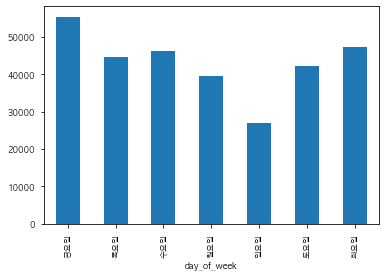

In [23]:
# 한글깨짐
df.groupby(['day_of_week']).count()['actiontype'].plot.bar();

In [24]:
df=df.drop(['day_of_week'],axis=1)

In [25]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


### 2.2 Missing value 확인

In [26]:
df.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

### 2.3 결측치 처리
* Drop
    * 경우에 따라 결측치 처리 방법이 달라진다.
    * 샘플수가 많다면 missing values 를 포함하는 행을 모두 삭제하는 것이 가능하다

In [27]:
# 결측치가 하나라도 있으면 버리는 코드 예제
df.dropna()

# 모든 값이 Null일 경우만 버리는 코드 예제
df.dropna(how='all')

# 결측치가 하나 이상 있는 Case만 선택하는 코드 예제
df[df.isnull().any(axis=1)]

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen


* Imputation
    * 만약 샘플수가 충분하지 않을 경우, Pandas의 fillna() 명령어로 Null 값을 채우는 것이 가능하다.
    * 연속형인 경우 Mean이나 Median을 이용하고 명목형인 경우 Mode(최빈치)나 예측 모형을 통해 Null 값을 대체할 수 있다.

In [28]:
# 날짜별,screen별 sessionid의 유니크한 개수카운트
# unstack() 을하면 컬럼별로 나열된 값을 행으로올려줌.
df_by_screen=df.groupby(['datetime','screen'])['sessionid'].nunique().unstack()
df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [29]:
df_by_screen.isnull().sum()

screen
InProduct_Mob    0
InProduct_Web    0
Main             0
Per_Dir          0
Pub_Dir          0
Purchase_done    6
Purchase_page    0
dtype: int64

In [30]:
df_by_screen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-07-01 to 2016-07-30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InProduct_Mob  30 non-null     float64
 1   InProduct_Web  30 non-null     float64
 2   Main           30 non-null     float64
 3   Per_Dir        30 non-null     float64
 4   Pub_Dir        30 non-null     float64
 5   Purchase_done  24 non-null     float64
 6   Purchase_page  30 non-null     float64
dtypes: float64(7)
memory usage: 1.9 KB


* 비즈니스 맥락 및 목적(퍼널분석)을 고려했을 때, 이 경우는 결측치를 0으로 처리하는 것이 적당하다고 판단됨.
    * 해당 날짜에 구매완료 페이지에 도달한 사용자가 없는 개념 = 0

In [31]:
df_by_screen.fillna(0)[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,0.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,0.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,0.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [32]:
df_by_screen.dropna(how='any')[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0
2016-07-10,62.0,122.0,1872.0,230.0,636.0,2.0,18.0
2016-07-12,138.0,157.0,3646.0,371.0,1000.0,4.0,26.0
2016-07-13,132.0,172.0,3544.0,334.0,988.0,1.0,35.0


In [33]:
# NaN이 하나라도있는 것만 추출.
df_by_screen[df_by_screen.isnull().any(axis=1)]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-11,125.0,139.0,2944.0,332.0,801.0,NaN,26.0
2016-07-18,133.0,162.0,2882.0,317.0,841.0,NaN,30.0
2016-07-19,124.0,137.0,3552.0,331.0,934.0,NaN,24.0


In [34]:
# median값으로 결측치 채우기
df_by_screen.fillna(df_by_screen.median())[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,2.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,2.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,2.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


### 2.4 결측치가 카테고리 변수인 경우
* Option 1. 최빈치(mode)
    * 쉽고 빠르게 이용가능하나, 낮은 적절성
* Option 2. 예측모형으로 예측치
    * 적절성은 비교적 높으나 별도의 모형과 계산량 필요

In [35]:
df_ms=df.copy()  # it helps to test any code or functions

# 임의로 nan값 으로 변경함.
## ix대신 iloc, loc 사용 
df_ms.loc[2,'documentposition']=np.nan
df_ms.loc[5,'documentposition']=np.nan
df_ms.loc[7,'documentposition']=np.nan
df_ms.loc[10,'documentposition']=np.nan
df_ms.loc[11,'documentposition']=np.nan
df_ms.loc[15,'documentposition']=np.nan

In [36]:
df_ms.loc[2,'documentposition']

nan

In [37]:
df_ms.iloc[2,4]

nan

In [38]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [39]:
df_ms.documentposition.value_counts()

OTHERAPP          213775
MYPOLARISDRIVE     55518
LOCALSTORAGE       18922
NEWDOCUMENT         7612
NONE                4335
OTHERCLOUD          1617
SHAREDDOCUMENT        76
Name: documentposition, dtype: int64

In [40]:
# 가장 많이 나온값 
freq_values=df_ms.documentposition.value_counts().index[0]
freq_values

'OTHERAPP'

In [41]:
df_ms['documentposition']=df_ms['documentposition'].fillna(freq_values)

In [42]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,OTHERAPP,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


**이번에는 머신러닝 모델로 null값을 채워보자**

In [115]:
df_ms.loc[2,'documentposition']=np.nan
df_ms.loc[5,'documentposition']=np.nan
df_ms.loc[7,'documentposition']=np.nan
df_ms.loc[10,'documentposition']=np.nan
df_ms.loc[11,'documentposition']=np.nan
df_ms.loc[15,'documentposition']=np.nan
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [116]:
# fill na using predictive model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# train데이터는 na값 없는것으로 훈련
df_ms1=df_ms.dropna()

# 독립변수 세팅
ind_cols=['actiontype','ismydoc','ext','screen']

# split ind, tar
## X,y 모두 na값은 없는상태
X=df_ms1[ind_cols]
y=df_ms1[['documentposition']]

In [117]:
X.head(10)

,actiontype,ismydoc,ext,screen
0,OPEN,NoView,PDF,Per_Dir
1,CLOSE,NoView,PDF,Per_Dir
3,CLOSE,View,PDF,Pub_Dir
4,OPEN,NoView,PDF,Main
6,CLOSE,NoView,PDF,Main
8,OPEN,NoView,PDF,Main
9,CLOSE,NoView,PDF,Main
12,CLOSE,NoView,PDF,Main
13,RESET,View,PDF,Main
14,OPEN,View,PDF,Pub_Dir


In [118]:
y[:10]

,documentposition
0,LOCALSTORAGE
1,LOCALSTORAGE
3,MYPOLARISDRIVE
4,OTHERAPP
6,OTHERAPP
8,OTHERAPP
9,OTHERAPP
12,OTHERAPP
13,OTHERAPP
14,MYPOLARISDRIVE


* LabelEncoder로 범주형을 숫자로 변경
    * 하는 이유 :
        기본적으로 사이킷런의 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않는다. <br>
        그렇기 때문에 모든 문자열 값들을 숫자 형으로 인코딩하는 전처리 작업 후에 머신러닝 모델에 학습을 시켜야한다.
    * LabelEncoder문제점
        * 일괄적인 숫자 값으로 변환되면서 예측 성능이 떨어질 수 있다.<br>
            숫자의 크고 작음에 대한 특성이 작용
        * 선형 회귀와 같은 ML 알고리즘에는 적용하지 않아야 함 (트리 계열의 ML알고리즘은 숫자의 이러한 특성을 반영하지 않으므로 괜찮음)


In [119]:
from sklearn.preprocessing import LabelEncoder
# 이름으로 되어있는 것을 숫자로 혹은 그 반대로 변환하는 것
encoder=LabelEncoder()

X=X.apply(lambda x: encoder.fit_transform(x))
y=y.apply(lambda x: encoder.fit_transform(y))

In [120]:
X.head(10)

,actiontype,ismydoc,ext,screen
0,3,0,5,3
1,0,0,5,3
3,0,1,5,4
4,3,0,5,2
6,0,0,5,2
8,3,0,5,2
9,0,0,5,2
12,0,0,5,2
13,4,1,5,2
14,3,1,5,4


In [121]:
y[:10]

,documentposition
0,0
1,0
3,1
4,4
6,4
8,4
9,4
12,4
13,4
14,1


* 먼저 NaN 값이 없는 데이터로 훈련시켜서 모델을 만들고, NaN값만 있는 데이터를 모델에 넣어서 예측하는 방식

In [122]:
## the cross validation phase
# X: df_ms_ind / y: df_ms_tar
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=10)

In [123]:
print(X.shape)
print(y.shape)

(301855, 4)
(301855, 1)


In [124]:
print(X_train.shape, y_train.shape)

(226391, 4) (226391, 1)


In [125]:
print(X_test.shape, y_test.shape)

(75464, 4) (75464, 1)


### KNN Algorithm
지도학습 알고리즘으로 가장 고전적이면서 직관적인 방법 <br>

**분류와 군집의 차이**
* 분류는 정답이 있는 데이터(라벨)을 지도학습을 통해 분류하는 것
* 군집화는 정답이 없는 데이터를 클러스터링하는 방법

**KNN 기본 로직**
> * 새로운 샘플 가까운 거리에 있는 몇 가지 라벨을 함께 본다.
    * 유클리드거리
* 그리고 가장 빈도가 높은 것을 통해 분류한다.
    * K의 개수 (K=7이면 7개로 묶었을때 ClassA의 개수와 ClassB의 개수를 카운팅해서 새로운 샘플을 더 많은 개수가있는 Class에 분류)
        * 여기서 주의할 점은 K의 개수가 짝수일 경우에는 동점이 발생할 수 있기에 홀수로 지정해줘야 한다.

In [103]:
from sklearn.neighbors import KNeighborsClassifier

# 훈련 데이터셋으로 부터 모델을 만들기 위해 knn객체를 만들고 fit 메소드 사용
knn=KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [104]:
# Quiz. score 의미가 무엇일까?
## So for classification, this is typically accuracy and for regression mean squared error.
print(knn.score(X_train,y_train))

0.9998719030350146


In [105]:
# test데이터로 예측한값과 실제 y_test값
print(knn.score(X_test, y_test)) # 만약 train 에서 score가 높고 test에서 score가 낮았다면?

0.9997879783737941


In [106]:
knn_pred=knn.predict(X_test)
knn_pred[:20]

array([1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 2, 4, 1, 4, 0, 4, 1, 4, 4])

In [107]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, knn_pred))

[[ 4733     0     0     0     3     0     0]
 [    2 13895     0     0     0     0     0]
 [    0     0  1920     0     3     0     0]
 [    0     0     2  1085     0     0     0]
 [    1     0     1     0 53383     0     0]
 [    0     1     0     0     0   413     0]
 [    0     3     0     0     0     0    19]]


In [108]:
from sklearn.metrics import classification_report

print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4736
           1       1.00      1.00      1.00     13897
           2       1.00      1.00      1.00      1923
           3       1.00      1.00      1.00      1087
           4       1.00      1.00      1.00     53385
           5       1.00      1.00      1.00       414
           6       1.00      0.86      0.93        22

    accuracy                           1.00     75464
   macro avg       1.00      0.98      0.99     75464
weighted avg       1.00      1.00      1.00     75464



In [109]:
pd.Series(knn_pred).value_counts().sort_index()

0     4736
1    13899
2     1923
3     1085
4    53389
5      413
6       19
dtype: int64

In [126]:
# 실제값과 매핑
class_cd=pd.Series(encoder.classes_).to_dict()
class_cd

{0: 'LOCALSTORAGE',
 1: 'MYPOLARISDRIVE',
 2: 'NEWDOCUMENT',
 3: 'NONE',
 4: 'OTHERAPP',
 5: 'OTHERCLOUD',
 6: 'SHAREDDOCUMENT'}

In [70]:
# let's impute the null values with the knn predictive model
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [71]:
df_ms.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    6
datetime            0
screen              0
dtype: int64

In [77]:
# NaN이 하나라도있으면 (any)
df_ms_only=df_ms[df_ms.isnull().any(axis=1)]
df_ms_only

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NaN,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NaN,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NaN,2016-07-24,Pub_Dir


In [78]:
# NaN 전부 drop한 데이터 따로저장.
df_ms_dropna=df_ms.dropna()
df_ms_dropna.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main


In [79]:
# predict missing categorical vars
df_ms_only[ind_cols].apply(lambda x: encoder.fit_transform(x))

,actiontype,ismydoc,ext,screen
2,1,1,0,1
5,2,1,0,0
7,1,0,0,0
10,1,1,0,0
11,1,0,0,0
15,0,1,0,1


In [80]:
knn.predict(df_ms_only[ind_cols].apply(lambda x: encoder.fit_transform(x)))

array([2, 2, 3, 3, 3, 3])

In [139]:
# class_cd=pd.Series(encoder.classes_).to_dict()
class_cd

{0: 'LOCALSTORAGE',
 1: 'MYPOLARISDRIVE',
 2: 'NEWDOCUMENT',
 3: 'NONE',
 4: 'OTHERAPP',
 5: 'OTHERCLOUD',
 6: 'SHAREDDOCUMENT'}

In [86]:
fill_na_values=knn.predict(df_ms_only[ind_cols].apply(lambda x: encoder.fit_transform(x)))
fill_na_values

array([2, 2, 3, 3, 3, 3])

In [133]:
df_ms_only['documentposition']=fill_na_values

In [135]:
df_ms_only.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,2,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,2,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,3,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,3,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,3,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,3,2016-07-24,Pub_Dir


In [140]:
df_ms_only['documentposition']

2     2
5     2
7     3
10    3
11    3
15    3
Name: documentposition, dtype: int64

In [143]:
# 딕셔너리에서 숫자에 해당하는 value값으로 치환하고 싶을때 replace() 사용
# 다른방법
# df_ms_only['documentposition'].apply(lambda x: class_cd[x])
df_ms_only['documentposition']=df_ms_only['documentposition'].replace(class_cd)

In [145]:
df_ms_only.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NEWDOCUMENT,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NEWDOCUMENT,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NONE,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NONE,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NONE,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NONE,2016-07-24,Pub_Dir


In [147]:
# na값 drop한 데이터와 na값 KNN으로 채워넣은 데이터 붙이기
df_ms_final=pd.concat([df_ms_dropna, df_ms_only],axis=0)
df_ms_final.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
12,CLOSE,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,OTHERAPP,2016-07-19,Main
13,RESET,View,PDF,9e37751e132b5eb96e7d3fde7db132e3,OTHERAPP,2016-07-19,Main
14,OPEN,View,PDF,450e74586e6a05f2983905205e8f8cb1,MYPOLARISDRIVE,2016-07-24,Pub_Dir


In [148]:
# NaN값 채우기 완료
df_ms_final.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

### 2.5 확장자명 통일


In [149]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [150]:
df.ext.value_counts()

PDF      82004
DOCX     58303
XLSX     52118
HWP      26244
DOC      24586
XLS      24489
PPTX     15385
TXT       9814
PPT       5382
PPSX      2374
ODT        820
PPS        324
JPG          9
SHEET        5
PNG          2
WORD         2
Name: ext, dtype: int64

In [151]:
ext_dic = {'DOCX': 'DOC',
           'XLSX': 'XLS',
           'PPTX': 'PPT',
           'PPSX': 'PPT',
           'PPS': 'PPT',
           'ODT': 'TXT',
           'PNG': 'JPG'}

In [155]:
df['ext'] = df['ext'].replace(ext_dic)

In [156]:
df['ext'].value_counts()

DOC      82889
PDF      82004
XLS      76607
HWP      26244
PPT      23465
TXT      10634
JPG         11
SHEET        5
WORD         2
Name: ext, dtype: int64

### 2.6 Action Type 통일¶

In [157]:
df.actiontype.value_counts()

OPEN            151802
CLOSE           127922
SAVE              9334
RESET             7751
SAVEAS            4960
EXPORT_SAME         68
EXPORT              19
SAVEAS_OTHER         5
Name: actiontype, dtype: int64

In [158]:
act_dic = {'SAVEAS': 'SAVE',
           'SAVEAS_OTHER': 'SAVE',
           'EXPORT_SAME': 'EXPORT'
            }

In [160]:
df['actiontype'] = df['actiontype'].replace(act_dic)

In [161]:
df['actiontype'].value_counts()

OPEN      151802
CLOSE     127922
SAVE       14299
RESET       7751
EXPORT        87
Name: actiontype, dtype: int64

### 2.7 신규 session_id 부여
* 필수는 아니나, 계산량 감소를 위해 텍스트 사이즈 감량

In [164]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [163]:
len(df)

301861

In [167]:
df['sessionid'].iloc[0]

'9400fd2e43d7dc2d054ca78806236ee1'

In [169]:
s=[]
j=0  # 초기값

for i in range(len(df)-1):   # 현재행과 그다음행을 비교해야되기 때문에 i는 df길이보다 하나적어야함.
    if df['sessionid'].iloc[i]==df['sessionid'].iloc[i+1]:   # 현재행과 다음행의 세션id가 같으면
        s.append(j)   # j값 그대로 append
    else:
        s.append(j)  
        j+=1  # 현재행과 다음행의 세션id가 다르면 j를 1 올려줌.

In [172]:
s[:20]

[0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 7]

In [179]:
# 전체 df 길이는 301861인데 마지막에 하나가 없음.
len(s)

301860

In [176]:
df['sessionid']  = pd.Series(['sess' + str(x) for x in s]) # convert to string as add character 's'

In [177]:
df.head(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,sess0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,sess0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,sess0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,sess0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,sess1,OTHERAPP,2016-07-06,Main


In [178]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,sess132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,sess132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,sess132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,sess132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,NaN,OTHERAPP,2016-07-14,Main


In [188]:
len(set(s))

132154

**Quiz. 마지막 301860 행의 sessionid NaN 값을 바로 위의 값 ses132153 으로 대체하려면?**

In [199]:
df['sessionid'][-1:]=pd.Series(['sess'+str(s[-1])])

In [200]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,sess132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,sess132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,sess132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,sess132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,sess132153,OTHERAPP,2016-07-14,Main


--------------------------------------------------------
## 3. EDA (탐색적 데이터 분석)